In [1]:
# Class dependencies
from model import OrigamiNetwork
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.datasets import load_digits

Epoch 298/300 - Train Acc: 1.0000 - Val Acc: 0.9479: 100%|██████████| 300/300 [00:01<00:00, 274.52it/s]


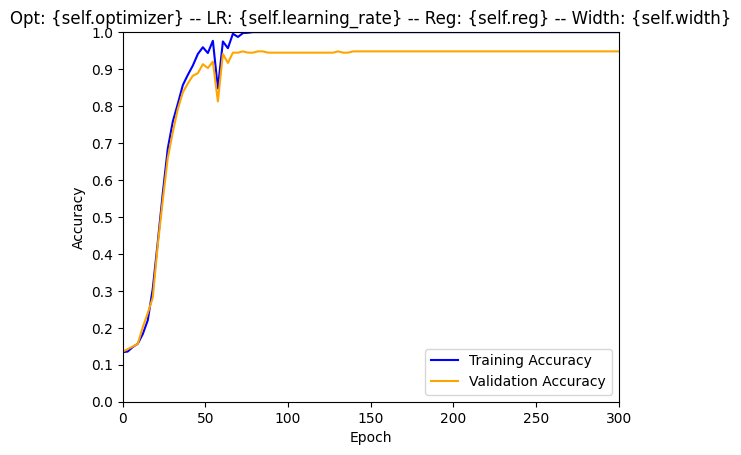

0.9527777777777777


In [6]:
# import small digits dataset

digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# set up the model
model = OrigamiNetwork(layers=0, epochs=300, optimizer='sgd',learning_rate=0.001)
model.fit(X_train, y_train, X_val, y_val)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))


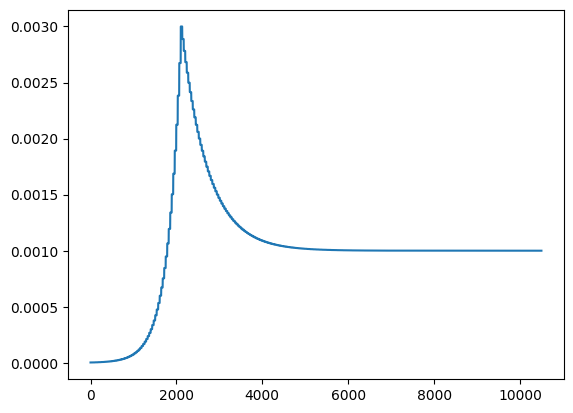

In [3]:
plt.plot(model.learning_rate_history)
plt.show()

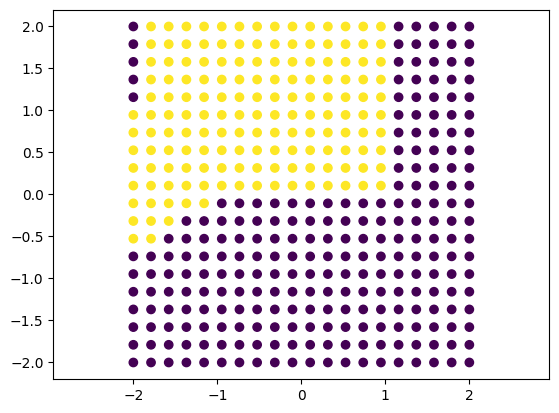

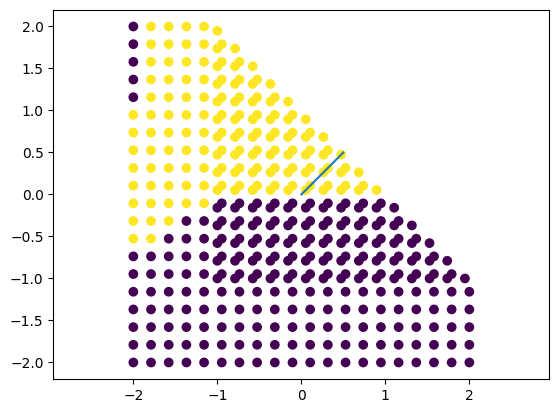

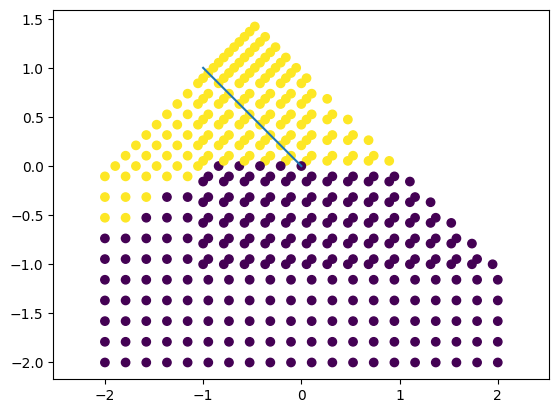

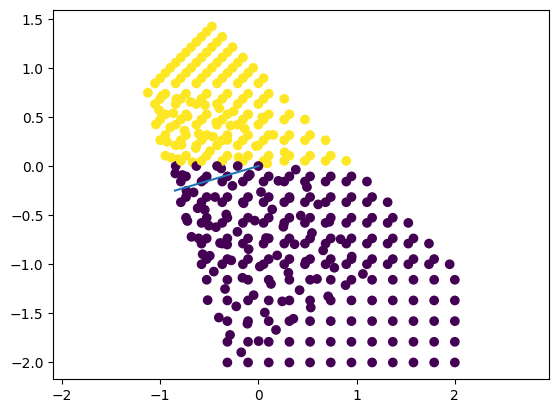

Epoch 1000/1000: 100%|██████████| 1000/1000 [00:04<00:00, 227.99it/s]


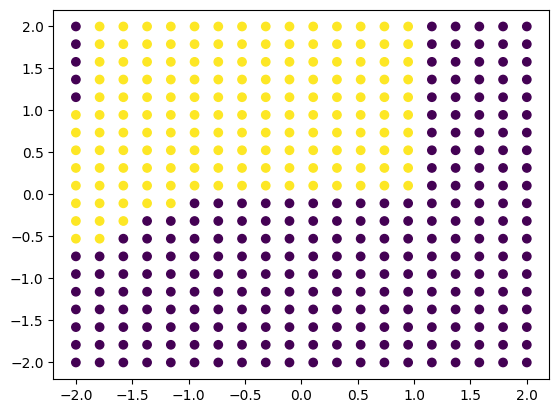

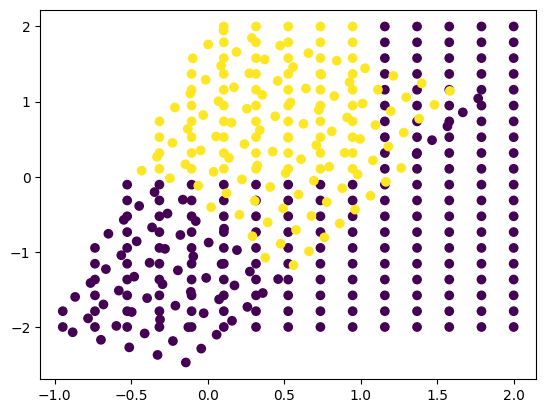

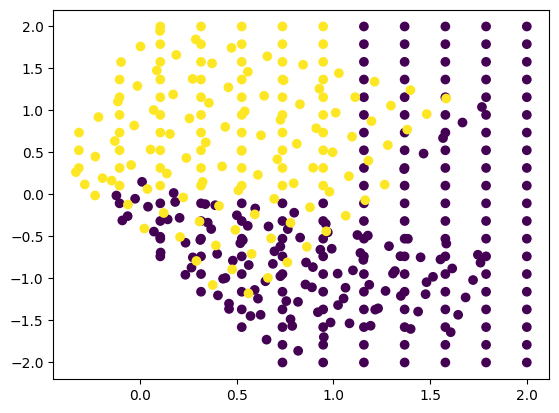

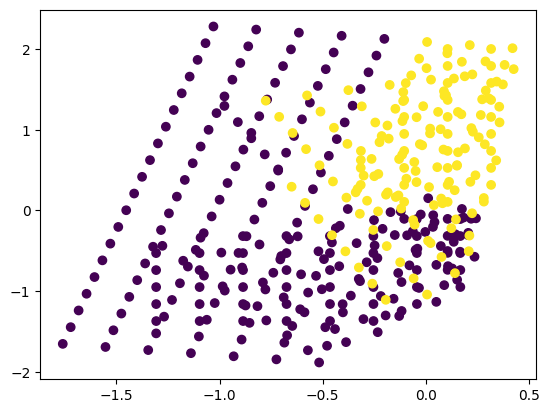

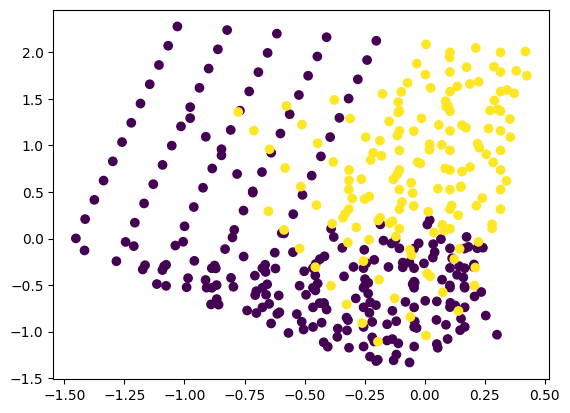

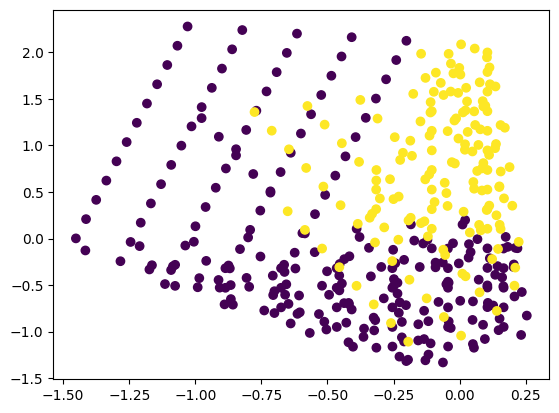

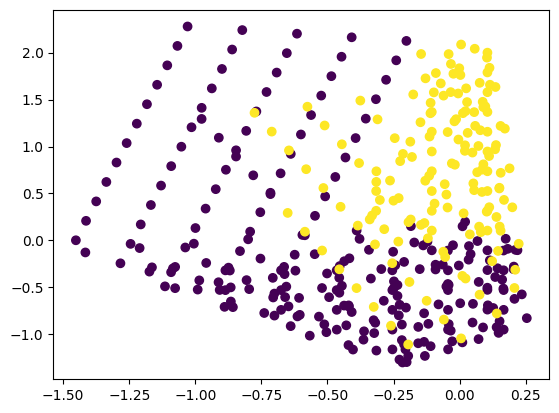

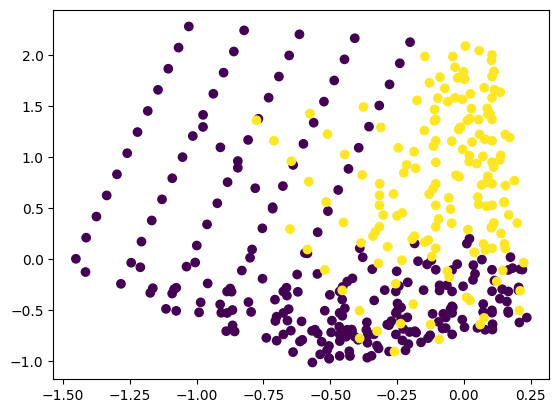

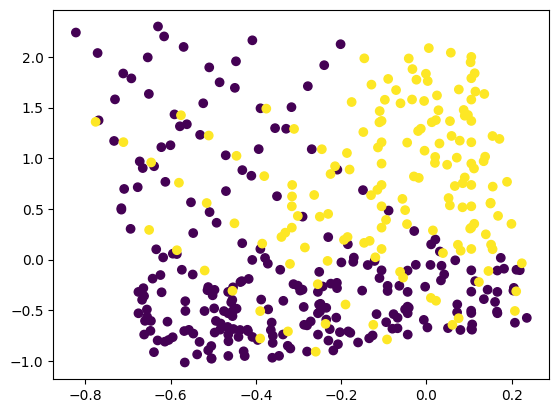

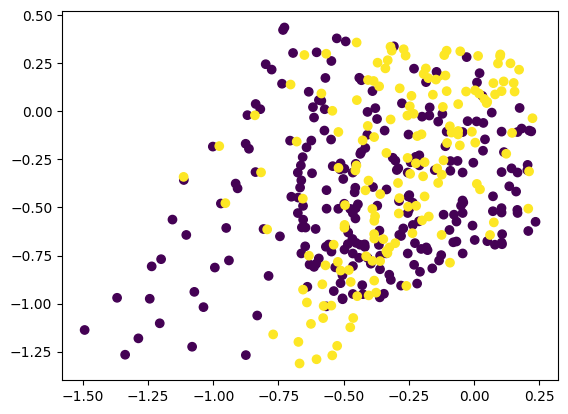

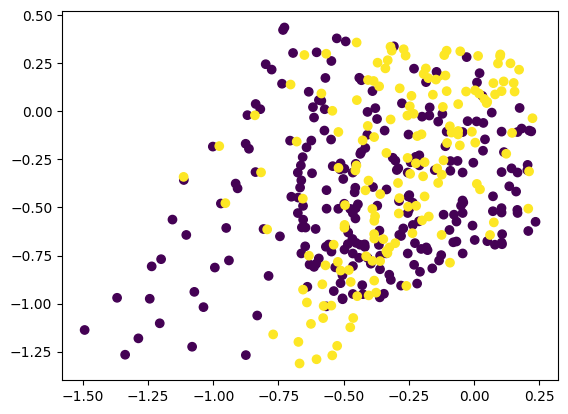

0.6475


In [4]:
layer = lambda D, n: D - 2 * np.outer((D@n)/np.dot(n, n), n)
def layer(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    projected = 2 * np.outer(scales, n)
    adjustment = 2*n - projected
    return D + mask[:,np.newaxis] * adjustment

crease = .5

# def layer(Z, n):
#     # Get the helpful terms to substitute into our fold function
#     z_dot_x = (Z@n)
#     n_dot_n = np.dot(n, n)
#     scales = z_dot_x / n_dot_n
#     p = crease * (z_dot_x - n_dot_n)
#     sigmoid = 1/(1 + np.exp(-p))
    
#     # Make the projection and flip the points that are beyond the fold
#     projected = np.outer(1-scales, n)
#     return Z + 2* sigmoid[:,np.newaxis] * projected


fv1 = .5*np.array([1,1])
fv2 = np.array([-1,1])
fv3 = np.array([-.85,-.25])


# make a meshgrid of x and y values
x1 = np.linspace(-2,2,20)
x2 = np.linspace(-2,2,20)
X1,X2 = np.meshgrid(x1,x2)

# reshape the meshgrid into a 2D array and concatenate them
X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
pairs = np.concatenate((X1,X2),axis=1)
cut1 = layer(pairs, fv1)
cut2 = layer(cut1, fv2)
cut = layer(cut2, fv3)
Y = cut[:,1] > 0

plt.scatter(pairs[:,0],pairs[:,1], c = Y)
plt.axis('equal')
plt.show()

plt.scatter(cut1[:,0],cut1[:,1], c = Y)
plt.plot([0,fv1[0]],[0,fv1[1]])
plt.axis('equal')
plt.show()

plt.scatter(cut2[:,0],cut2[:,1], c = Y)
plt.plot([0,fv2[0]],[0,fv2[1]])
plt.axis('equal')
plt.show()

plt.scatter(cut[:,0],cut[:,1], c = Y)
plt.plot([0,fv3[0]],[0,fv3[1]])
plt.axis('equal')
plt.show()

test = OrigamiNetwork(layers = 10, learning_rate=0.01, reg=0, optimizer="sgd", batch_size=32, epochs=1000)
test.fit(pairs,Y)
out = test.forward_pass(pairs)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = Y)
    # plt.plot([0,test.fold_vectors[i][0]],[0,test.fold_vectors[i][1]])
    plt.show()
    
print(accuracy_score(Y, test.predict(pairs)))

# test.back_propagation(np.arange(10))
# print(forward)
# print([(i, test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)])
# [test.derivative_fold(forward[i], test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)]

In [5]:
1

1